### Step 1 : Import Modules

In [20]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

### Step 2 : Read Data

In [2]:
data = pd.read_csv('news.csv')

In [3]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
data.shape

(6335, 4)

In [8]:
data.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [15]:
data['label'] = data['label'].replace(['FAKE','REAL'],[1,0])

In [16]:
data['label']

0       1
1       1
2       0
3       1
4       0
       ..
6330    0
6331    1
6332    1
6333    0
6334    0
Name: label, Length: 6335, dtype: int64

In [24]:
x = data[['text']]
y = data['label']

### Step 3 : Split the dataset into training and testing sets.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y)

In [27]:
x_train['text']

4611    Ivana Says Young Donald Trump Was A Cry-Baby –...
5706    The US economy added just 38,000 jobs in May –...
3656    Genius Kid Trolled White House Halloween Party...
4743    Orrin Hatch, one of the senior Republicans on ...
1074    Pope Francis has been brushing up on his Engli...
                              ...                        
2274    Donald Trump made his most direct appeal to Af...
4438    BNI Store Nov 7 2016 HERE THEY GO AGAIN! Musli...
2416    Reuters \nPolice arrested 141 Native Americans...
5093    source Add To The Conversation Using Facebook ...
202     Two more women accused Republican nominee Dona...
Name: text, Length: 4244, dtype: object

<h3>Step 4 : Encoding Text using TFIDF Vectorizer</h3>

In [32]:
tfidf_vectorizer=TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
tfidf_vectorizer.fit(x_train['text'].values)

x_train = tfidf_vectorizer.transform(x_train['text'].values)
x_test = tfidf_vectorizer.transform(x_test['text'].values)

In [44]:
x_train = x_train.toarray()
x_test = x_test.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [34]:
print("Before vectorizations")
print(x_train.shape, y_train.shape)

print(x_test.shape, y_test.shape)
print("="*100)
print("After vectorizations")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Before vectorizations
(4244, 5000) (4244,)
(2091, 5000) (2091,)
After vectorizations
(4244, 5000) (4244,)
(2091, 5000) (2091,)


### Step 5 : The hyper paramter tuning and trainig on best model

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import numpy as np

alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
class_prior = [0.5, 0.5]

model = MultinomialNB(fit_prior=False, class_prior=class_prior)



params = {'alpha':alpha}

classifier = GridSearchCV(model,params,cv=5,verbose=1,scoring='roc_auc',return_train_score=True)

search = classifier.fit(x_train,y_train)

search.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   15.8s finished


{'alpha': 1e-05}

<h3> Step 6 :Training using best hyper parameters and  Plot between FPR and TPR</h4>

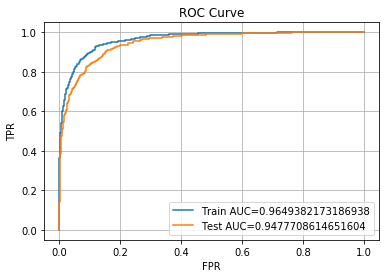

In [53]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
# Best parameters
alpha = 1e-05

classifier=MultinomialNB(fit_prior=False, class_prior=class_prior)
classifier.fit(x_train, y_train)

y_train_pred = classifier.predict_proba(x_train)   
y_test_pred = classifier.predict_proba(x_test)

fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train, y_train_pred[:,1], pos_label=1)

fpr_te, tpr_te, thresholds_te = roc_curve(y_test, y_test_pred[:,1], pos_label=1)

plt.plot(fpr_tr,tpr_tr, label='Train AUC='+str(auc(fpr_tr,tpr_tr)))
plt.plot(fpr_te, tpr_te, label='Test AUC='+str(auc(fpr_te, tpr_te)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [54]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [56]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix,classification_report
best_t = find_best_threshold(thresholds_te, fpr_te, tpr_te)
print("Test confusion matrix")
pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred[:,1], best_t)),index=['Actual Negative Class','Actual Positive Class'],columns=['Predicted Negative Class','Predicted Positive Class'])


the maximum value of tpr*(1-fpr) 0.7674270951121065 for threshold 0.48
Test confusion matrix


,Predicted Negative Class,Predicted Positive Class
Actual Negative Class,883,164
Actual Positive Class,94,950


In [58]:
print(classification_report(y_test, predict_with_best_t(y_test_pred[:,1], best_t)))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1047
           1       0.85      0.91      0.88      1044

    accuracy                           0.88      2091
   macro avg       0.88      0.88      0.88      2091
weighted avg       0.88      0.88      0.88      2091



### Conclusin

Our naive bayes model has Performed somewhat well as naive bayes is best suited for text data.